https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [13]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 16
        
        self.conv = conv3x3(in_channels=3, out_channels=16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=16, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=32, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=64, blocks=layers[2], stride=2)
        self.layer4 = self.make_layer(block=block, out_channels=128, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])
    # return ResNet(ResidualBlock, [2, 2, 2])

In [14]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [15]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [16]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [17]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [18]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [20]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 80

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")
  

EPOCHS : 0


Batch_id=87 Batch Loss=0.1456586718559265 Running Loss=13.194626033306122 Running Accuracy=94.69: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0010, Accuracy: 4277/5000 (85.54%)


Test set: Average loss: 0.5320, Accuracy: 8525/10000 (85.25%)

EPOCHS : 1


Batch_id=87 Batch Loss=0.16701123118400574 Running Loss=13.170863822102547 Running Accuracy=94.65: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0010, Accuracy: 4286/5000 (85.72%)


Test set: Average loss: 0.5374, Accuracy: 8563/10000 (85.63%)

EPOCHS : 2


Batch_id=87 Batch Loss=0.15183120965957642 Running Loss=12.855501629412174 Running Accuracy=94.81: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0011, Accuracy: 4243/5000 (84.86%)


Test set: Average loss: 0.6041, Accuracy: 8418/10000 (84.18%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.11908059567213058 Running Loss=12.766556188464165 Running Accuracy=94.88: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4276/5000 (85.52%)


Test set: Average loss: 0.5411, Accuracy: 8482/10000 (84.82%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.11770614236593246 Running Loss=12.968167744576931 Running Accuracy=94.76: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]



Validation set: Average loss: 0.0014, Accuracy: 4098/5000 (81.96%)


Test set: Average loss: 0.7096, Accuracy: 8159/10000 (81.59%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.18253843486309052 Running Loss=12.476010173559189 Running Accuracy=94.92: 100%|██████████| 88/88 [00:29<00:00,  2.93it/s]



Validation set: Average loss: 0.0013, Accuracy: 4182/5000 (83.64%)


Test set: Average loss: 0.6496, Accuracy: 8343/10000 (83.43%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.19172298908233643 Running Loss=12.504250973463058 Running Accuracy=94.99: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]



Validation set: Average loss: 0.0012, Accuracy: 4176/5000 (83.52%)


Test set: Average loss: 0.6551, Accuracy: 8328/10000 (83.28%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.12385955452919006 Running Loss=12.355653710663319 Running Accuracy=95.06: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0011, Accuracy: 4254/5000 (85.08%)


Test set: Average loss: 0.6028, Accuracy: 8414/10000 (84.14%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.11368677765130997 Running Loss=12.028311111032963 Running Accuracy=95.18: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0010, Accuracy: 4319/5000 (86.38%)


Test set: Average loss: 0.5360, Accuracy: 8542/10000 (85.42%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.14227330684661865 Running Loss=11.702012650668621 Running Accuracy=95.32: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]



Validation set: Average loss: 0.0010, Accuracy: 4337/5000 (86.74%)


Test set: Average loss: 0.5299, Accuracy: 8563/10000 (85.63%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.1535143107175827 Running Loss=11.92087197303772 Running Accuracy=95.27: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0011, Accuracy: 4237/5000 (84.74%)


Test set: Average loss: 0.5908, Accuracy: 8430/10000 (84.30%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.17086106538772583 Running Loss=11.483164362609386 Running Accuracy=95.38: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]



Validation set: Average loss: 0.0009, Accuracy: 4334/5000 (86.68%)


Test set: Average loss: 0.5157, Accuracy: 8603/10000 (86.03%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.21231666207313538 Running Loss=11.571266524493694 Running Accuracy=95.36: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]



Validation set: Average loss: 0.0011, Accuracy: 4259/5000 (85.18%)


Test set: Average loss: 0.5876, Accuracy: 8448/10000 (84.48%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.1521703153848648 Running Loss=11.402125410735607 Running Accuracy=95.43: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0011, Accuracy: 4289/5000 (85.78%)


Test set: Average loss: 0.5681, Accuracy: 8522/10000 (85.22%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.13510099053382874 Running Loss=10.864231631159782 Running Accuracy=95.66: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]



Validation set: Average loss: 0.0011, Accuracy: 4301/5000 (86.02%)


Test set: Average loss: 0.5514, Accuracy: 8568/10000 (85.68%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.16545256972312927 Running Loss=11.010235361754894 Running Accuracy=95.61: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0010, Accuracy: 4270/5000 (85.40%)


Test set: Average loss: 0.5691, Accuracy: 8504/10000 (85.04%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.12988147139549255 Running Loss=10.74097304791212 Running Accuracy=95.61: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]



Validation set: Average loss: 0.0010, Accuracy: 4289/5000 (85.78%)


Test set: Average loss: 0.5784, Accuracy: 8496/10000 (84.96%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.11718772351741791 Running Loss=10.70319639146328 Running Accuracy=95.68: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]



Validation set: Average loss: 0.0010, Accuracy: 4290/5000 (85.80%)


Test set: Average loss: 0.5537, Accuracy: 8571/10000 (85.71%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.1461208015680313 Running Loss=10.080404549837112 Running Accuracy=95.99: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0010, Accuracy: 4330/5000 (86.60%)


Test set: Average loss: 0.5572, Accuracy: 8553/10000 (85.53%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.09831790626049042 Running Loss=10.346077032387257 Running Accuracy=95.84: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]



Validation set: Average loss: 0.0011, Accuracy: 4290/5000 (85.80%)


Test set: Average loss: 0.5821, Accuracy: 8511/10000 (85.11%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.10453089326620102 Running Loss=10.400889210402966 Running Accuracy=95.79: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]



Validation set: Average loss: 0.0010, Accuracy: 4314/5000 (86.28%)


Test set: Average loss: 0.5545, Accuracy: 8595/10000 (85.95%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.1322549432516098 Running Loss=10.574814535677433 Running Accuracy=95.61: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]



Validation set: Average loss: 0.0011, Accuracy: 4232/5000 (84.64%)

Epoch 00102: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.6226, Accuracy: 8403/10000 (84.03%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.08022379130125046 Running Loss=8.160442110151052 Running Accuracy=96.78: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4389/5000 (87.78%)


Test set: Average loss: 0.4835, Accuracy: 8706/10000 (87.06%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.09377703070640564 Running Loss=6.976279515773058 Running Accuracy=97.30: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4399/5000 (87.98%)


Test set: Average loss: 0.4834, Accuracy: 8715/10000 (87.15%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.0934038981795311 Running Loss=6.508459564298391 Running Accuracy=97.53: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4824, Accuracy: 8728/10000 (87.28%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.07485990971326828 Running Loss=6.04611586406827 Running Accuracy=97.81: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0009, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.4832, Accuracy: 8723/10000 (87.23%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.0760100781917572 Running Loss=5.812205389142036 Running Accuracy=97.80: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]



Validation set: Average loss: 0.0009, Accuracy: 4412/5000 (88.24%)


Test set: Average loss: 0.4811, Accuracy: 8724/10000 (87.24%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.05904500186443329 Running Loss=5.753953330218792 Running Accuracy=97.90: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4401/5000 (88.02%)


Test set: Average loss: 0.4820, Accuracy: 8756/10000 (87.56%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.058371175080537796 Running Loss=5.796326868236065 Running Accuracy=97.85: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4403/5000 (88.06%)


Test set: Average loss: 0.4837, Accuracy: 8727/10000 (87.27%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.054133545607328415 Running Loss=5.513708885759115 Running Accuracy=98.02: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4802, Accuracy: 8745/10000 (87.45%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.05788879469037056 Running Loss=5.598317075520754 Running Accuracy=97.96: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4403/5000 (88.06%)


Test set: Average loss: 0.4798, Accuracy: 8737/10000 (87.37%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.06956090033054352 Running Loss=5.238508429378271 Running Accuracy=98.09: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]



Validation set: Average loss: 0.0009, Accuracy: 4409/5000 (88.18%)


Test set: Average loss: 0.4874, Accuracy: 8726/10000 (87.26%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.05659245699644089 Running Loss=5.448667578399181 Running Accuracy=97.96: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4410/5000 (88.20%)


Test set: Average loss: 0.4827, Accuracy: 8734/10000 (87.34%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.05602163076400757 Running Loss=5.277836631983519 Running Accuracy=98.14: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]



Validation set: Average loss: 0.0009, Accuracy: 4393/5000 (87.86%)


Test set: Average loss: 0.4869, Accuracy: 8726/10000 (87.26%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.05867743864655495 Running Loss=5.175932697951794 Running Accuracy=98.14: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]



Validation set: Average loss: 0.0009, Accuracy: 4403/5000 (88.06%)


Test set: Average loss: 0.4832, Accuracy: 8711/10000 (87.11%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.05063193291425705 Running Loss=5.1221112832427025 Running Accuracy=98.14: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]



Validation set: Average loss: 0.0009, Accuracy: 4408/5000 (88.16%)


Test set: Average loss: 0.4867, Accuracy: 8710/10000 (87.10%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.058220669627189636 Running Loss=5.100981691852212 Running Accuracy=98.20: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]



Validation set: Average loss: 0.0009, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4854, Accuracy: 8734/10000 (87.34%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.06962685286998749 Running Loss=4.927091386169195 Running Accuracy=98.19: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4874, Accuracy: 8718/10000 (87.18%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.06992772221565247 Running Loss=4.874527178704739 Running Accuracy=98.21: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4858, Accuracy: 8741/10000 (87.41%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.06593944877386093 Running Loss=5.015618050470948 Running Accuracy=98.16: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4886, Accuracy: 8722/10000 (87.22%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.04744870215654373 Running Loss=4.9182913564145565 Running Accuracy=98.22: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4891, Accuracy: 8730/10000 (87.30%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.05105290934443474 Running Loss=4.778773061931133 Running Accuracy=98.32: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.4931, Accuracy: 8716/10000 (87.16%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.041584521532058716 Running Loss=4.792840983718634 Running Accuracy=98.27: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]



Validation set: Average loss: 0.0009, Accuracy: 4400/5000 (88.00%)


Test set: Average loss: 0.4913, Accuracy: 8711/10000 (87.11%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.04692690819501877 Running Loss=4.6645165756344795 Running Accuracy=98.37: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]



Validation set: Average loss: 0.0009, Accuracy: 4410/5000 (88.20%)


Test set: Average loss: 0.4917, Accuracy: 8737/10000 (87.37%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.053816523402929306 Running Loss=4.760089902207255 Running Accuracy=98.26: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]



Validation set: Average loss: 0.0009, Accuracy: 4413/5000 (88.26%)


Test set: Average loss: 0.4916, Accuracy: 8724/10000 (87.24%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.041248492896556854 Running Loss=4.787769451737404 Running Accuracy=98.26: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]



Validation set: Average loss: 0.0009, Accuracy: 4398/5000 (87.96%)


Test set: Average loss: 0.4939, Accuracy: 8716/10000 (87.16%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.03846519812941551 Running Loss=4.625974604859948 Running Accuracy=98.34: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]



Validation set: Average loss: 0.0009, Accuracy: 4404/5000 (88.08%)


Test set: Average loss: 0.4942, Accuracy: 8729/10000 (87.29%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.050664812326431274 Running Loss=4.68991307541728 Running Accuracy=98.24: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0009, Accuracy: 4410/5000 (88.20%)


Test set: Average loss: 0.4952, Accuracy: 8739/10000 (87.39%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.04266425594687462 Running Loss=4.544043453410268 Running Accuracy=98.41: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]



Validation set: Average loss: 0.0009, Accuracy: 4406/5000 (88.12%)


Test set: Average loss: 0.4934, Accuracy: 8741/10000 (87.41%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.04810665547847748 Running Loss=4.480180302634835 Running Accuracy=98.40: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4407/5000 (88.14%)


Test set: Average loss: 0.4936, Accuracy: 8739/10000 (87.39%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.04393419995903969 Running Loss=4.728885982185602 Running Accuracy=98.25: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4947, Accuracy: 8737/10000 (87.37%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.04635738208889961 Running Loss=4.5760620050132275 Running Accuracy=98.36: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4410/5000 (88.20%)


Test set: Average loss: 0.4932, Accuracy: 8735/10000 (87.35%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.06253224611282349 Running Loss=4.502468332648277 Running Accuracy=98.43: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0009, Accuracy: 4406/5000 (88.12%)

Epoch 00133: reducing learning rate of group 0 to 1.0000e-04.

Test set: Average loss: 0.4983, Accuracy: 8728/10000 (87.28%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.05085445195436478 Running Loss=4.422258865088224 Running Accuracy=98.48: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]



Validation set: Average loss: 0.0009, Accuracy: 4408/5000 (88.16%)


Test set: Average loss: 0.4942, Accuracy: 8742/10000 (87.42%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.048443276435136795 Running Loss=4.36862525716424 Running Accuracy=98.39: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.4947, Accuracy: 8738/10000 (87.38%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.040555067360401154 Running Loss=4.24660812318325 Running Accuracy=98.45: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]



Validation set: Average loss: 0.0009, Accuracy: 4404/5000 (88.08%)


Test set: Average loss: 0.4944, Accuracy: 8741/10000 (87.41%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.05364607274532318 Running Loss=4.284996833652258 Running Accuracy=98.49: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]



Validation set: Average loss: 0.0009, Accuracy: 4415/5000 (88.30%)


Test set: Average loss: 0.4947, Accuracy: 8736/10000 (87.36%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.049419716000556946 Running Loss=4.444522498175502 Running Accuracy=98.36: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4938, Accuracy: 8747/10000 (87.47%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.04435420781373978 Running Loss=4.4016619846224785 Running Accuracy=98.35: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)

Epoch 00139: reducing learning rate of group 0 to 1.0000e-05.

Test set: Average loss: 0.4928, Accuracy: 8751/10000 (87.51%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.06359600275754929 Running Loss=4.408773170784116 Running Accuracy=98.39: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4949, Accuracy: 8743/10000 (87.43%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.033348701894283295 Running Loss=4.257287686690688 Running Accuracy=98.41: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]



Validation set: Average loss: 0.0009, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.4931, Accuracy: 8743/10000 (87.43%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.06078970804810524 Running Loss=4.16429990157485 Running Accuracy=98.54: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]



Validation set: Average loss: 0.0009, Accuracy: 4412/5000 (88.24%)


Test set: Average loss: 0.4932, Accuracy: 8742/10000 (87.42%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.035900216549634933 Running Loss=4.2590919472277164 Running Accuracy=98.50: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4415/5000 (88.30%)


Test set: Average loss: 0.4930, Accuracy: 8743/10000 (87.43%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.05177835375070572 Running Loss=4.332175377756357 Running Accuracy=98.45: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]



Validation set: Average loss: 0.0009, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4921, Accuracy: 8753/10000 (87.53%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.045704592019319534 Running Loss=4.217112755402923 Running Accuracy=98.46: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)

Epoch 00145: reducing learning rate of group 0 to 1.0000e-06.

Test set: Average loss: 0.4928, Accuracy: 8753/10000 (87.53%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.0665944293141365 Running Loss=4.400622230023146 Running Accuracy=98.45: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]



Validation set: Average loss: 0.0009, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4933, Accuracy: 8747/10000 (87.47%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.05024076998233795 Running Loss=4.29298341833055 Running Accuracy=98.50: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0009, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4933, Accuracy: 8742/10000 (87.42%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.054426003247499466 Running Loss=4.299601698294282 Running Accuracy=98.43: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4415/5000 (88.30%)

Epoch 00148: reducing learning rate of group 0 to 1.0000e-07.

Test set: Average loss: 0.4939, Accuracy: 8739/10000 (87.39%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.046009209007024765 Running Loss=4.185654688626528 Running Accuracy=98.56: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]



Validation set: Average loss: 0.0009, Accuracy: 4411/5000 (88.22%)


Test set: Average loss: 0.4921, Accuracy: 8754/10000 (87.54%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.039428357034921646 Running Loss=4.23431272059679 Running Accuracy=98.46: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4418/5000 (88.36%)


Test set: Average loss: 0.4934, Accuracy: 8745/10000 (87.45%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.04873502627015114 Running Loss=4.471442980691791 Running Accuracy=98.37: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)

Epoch 00151: reducing learning rate of group 0 to 1.0000e-08.

Test set: Average loss: 0.4935, Accuracy: 8745/10000 (87.45%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.043198857456445694 Running Loss=4.20219854824245 Running Accuracy=98.50: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]



Validation set: Average loss: 0.0009, Accuracy: 4422/5000 (88.44%)


Test set: Average loss: 0.4953, Accuracy: 8742/10000 (87.42%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.04968511313199997 Running Loss=4.2435651030391455 Running Accuracy=98.45: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4917, Accuracy: 8753/10000 (87.53%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.06512343138456345 Running Loss=4.300017096102238 Running Accuracy=98.50: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]



Validation set: Average loss: 0.0009, Accuracy: 4413/5000 (88.26%)


Test set: Average loss: 0.4951, Accuracy: 8738/10000 (87.38%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.03945504128932953 Running Loss=4.483328541740775 Running Accuracy=98.36: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0009, Accuracy: 4413/5000 (88.26%)


Test set: Average loss: 0.4948, Accuracy: 8739/10000 (87.39%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.05113846808671951 Running Loss=4.203468622639775 Running Accuracy=98.48: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]



Validation set: Average loss: 0.0009, Accuracy: 4408/5000 (88.16%)


Test set: Average loss: 0.4934, Accuracy: 8743/10000 (87.43%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.04633808135986328 Running Loss=4.232284499332309 Running Accuracy=98.48: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]



Validation set: Average loss: 0.0009, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4930, Accuracy: 8751/10000 (87.51%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.061111852526664734 Running Loss=4.000126590952277 Running Accuracy=98.61: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.4925, Accuracy: 8741/10000 (87.41%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.05136006325483322 Running Loss=4.268025470897555 Running Accuracy=98.53: 100%|██████████| 88/88 [00:31<00:00,  2.83it/s]



Validation set: Average loss: 0.0009, Accuracy: 4413/5000 (88.26%)


Test set: Average loss: 0.4937, Accuracy: 8739/10000 (87.39%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.0423472635447979 Running Loss=4.229338448494673 Running Accuracy=98.43: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]



Validation set: Average loss: 0.0009, Accuracy: 4417/5000 (88.34%)


Test set: Average loss: 0.4931, Accuracy: 8752/10000 (87.52%)



In [21]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.4931, Accuracy: 8752/10000 (87.52%)


Test set: Average loss: 0.4820, Accuracy: 8756/10000 (87.56%)



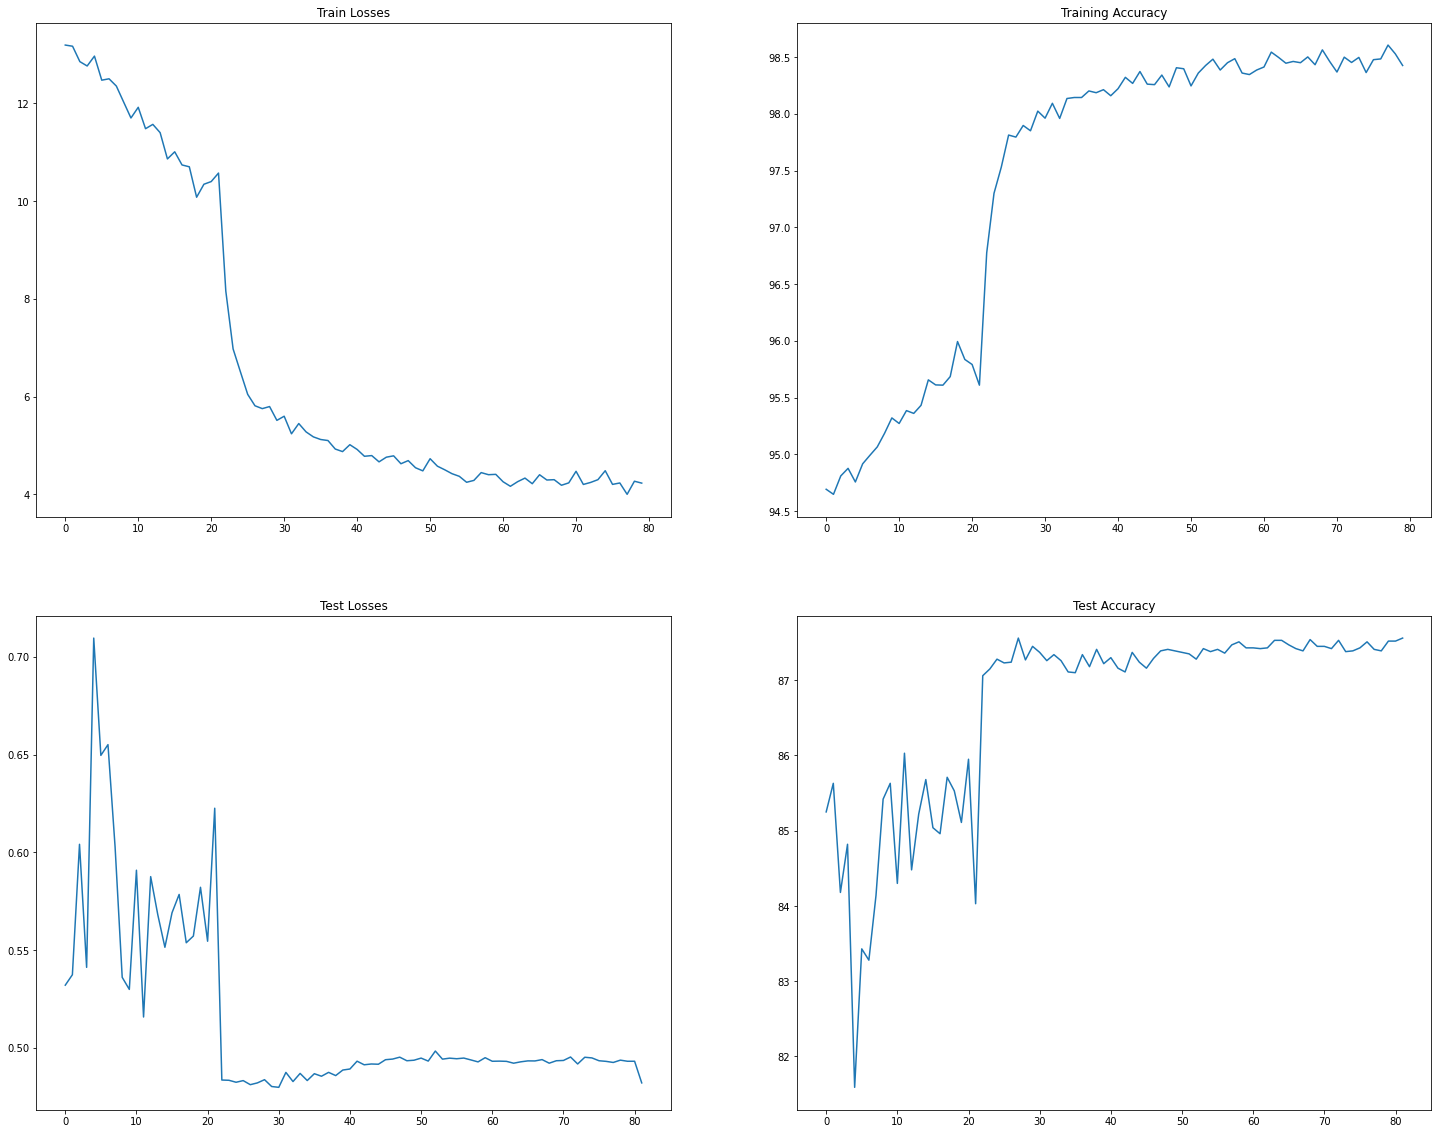

In [22]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)